In [10]:
import numpy as np
import pandas as pd
import geopandas as gpd
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, project_root)

In [11]:
df = pd.read_csv('../data/raw/all_crashes.csv')
df.head()

,geom,Num_Occupants,Num_MotorVehicles,Fatalities_calc,SuspectedSeriousInjury_calc,NonMotorist_calc,Aggregated_Non_Motorist_txt,CityTownship,CountyNameTxt,Region,...,LocalCodeTxt,doi_date,doi_time,doi_dow_txtCARTO,HitAndRunInd_txtCARTO,VehicleMakeModelYearTxt_list,VehicleTypeCde_txtCARTO_list,doi_hour_txtCARTO,CrashType,CrashDetail
0,POINT(-93.66935666 44.92911086),1,1,0,0,0,Motorist Only,MOUND,HENNEPIN,Metro,...,24010265,"September 30, 2024",01:00:00 PM,Monday,"No, Did not Leave Scene",2015 FORD ESCAPE,Sport Utility Vehicle,1:00 PM - 1:59 PM,Non-Collision,Immersion (Partial or Full)
1,POINT(-93.31948042 43.69167691),2,2,0,0,0,Motorist Only,BANCROFT,FREEBORN,Southeast,...,24104389,"September 30, 2024",06:41:00 AM,Monday,"No, Did not Leave Scene","2017 FORD FIESTA, 2021 KENWORTH TRUCK","Passenger Car, Medium / Heavy Trucks (More tha...",6:00 AM - 6:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport
2,POINT(-96.34675035 43.60859205),1,1,0,0,0,Motorist Only,BEAVER CREEK,ROCK,South Central,...,24000700,"September 30, 2024",04:17:00 AM,Monday,"No, Did not Leave Scene",2003 CHEVROLET 1500 SILVERADO LTZ,Pickup,4:00 AM - 4:59 AM,Collision w/ Fixed Object,Cable Median Barrier
3,POINT(-93.29405308 44.86186167),2,2,0,0,0,Motorist Only,BLOOMINGTON,HENNEPIN,Metro,...,24511549,"September 30, 2024",06:39:00 AM,Monday,"Yes, Driver or Car and Driver Left Scene","2014 CHEVROLET CRUZE, 2020 JEEP (POST 1988) GR...","Passenger Car, Sport Utility Vehicle",6:00 AM - 6:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport
4,POINT(-93.37451935 44.86024945),4,4,0,0,0,Motorist Only,BLOOMINGTON,HENNEPIN,Metro,...,24511554,"September 30, 2024",07:36:00 AM,Monday,"No, Did not Leave Scene","2013 TOYOTA RAV4, 2018 VOLVO VN, 2012 DODGE DU...","Sport Utility Vehicle, Medium / Heavy Trucks (...",7:00 AM - 7:59 AM,Collision w/ Non-Fixed Object,Motor Vehicle in Transport


In [12]:
from shapely import wkt
from src.preprocessing import generate_grid_tc_metro_area

df['geometry'] = df['geom'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs='EPSG:4326')

grid = generate_grid_tc_metro_area(gdf)
grid.head()

,cell_id,geometry
0,0_0,"POLYGON ((-94.42176 44.54218, -94.41546 44.542..."
1,0_1,"POLYGON ((-94.42166 44.54667, -94.41535 44.546..."
2,0_2,"POLYGON ((-94.42155 44.55116, -94.41525 44.551..."
3,0_3,"POLYGON ((-94.42145 44.55565, -94.41514 44.555..."
4,0_4,"POLYGON ((-94.42135 44.56014, -94.41504 44.560..."


In [13]:
from src.preprocessing import create_cell_day_df

cell_day_df = create_cell_day_df(gdf, grid, '2017-01-01', '2025-01-01')
cell_day_df.head()

,cell_id,date,num_crashes,crash_tomorrow
0,0_0,2017-01-01,0,0
1,0_0,2017-01-02,0,0
2,0_0,2017-01-03,0,0
3,0_0,2017-01-04,0,0
4,0_0,2017-01-05,0,0


In [14]:
cell_day_df.info()
cell_day_df.describe()
print(cell_day_df['num_crashes'].value_counts())
print(cell_day_df['crash_tomorrow'].mean())

<class 'pandas.core.frame.DataFrame'>
Index: 200566080 entries, 0 to 7132118
Data columns (total 4 columns):
 #   Column          Dtype         
---  ------          -----         
 0   cell_id         object        
 1   date            datetime64[ns]
 2   num_crashes     int64         
 3   crash_tomorrow  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ GB
num_crashes
0     200214211
1        337342
2         13040
3          1176
4           222
5            62
6            18
7             5
8             3
10            1
Name: count, dtype: int64
0.001754304616214267


In [15]:
pd.crosstab(cell_day_df['cell_id'], cell_day_df['crash_tomorrow'])



crash_tomorrow,0,1
cell_id,,
0_0,2922,0
0_1,2922,0
0_10,2922,0
0_100,2922,0
0_101,2922,0
...,...,...
9_95,2922,0
9_96,2922,0
9_97,2922,0


<Axes: title={'center': 'Total Crashes by Weekday'}, xlabel='weekday'>

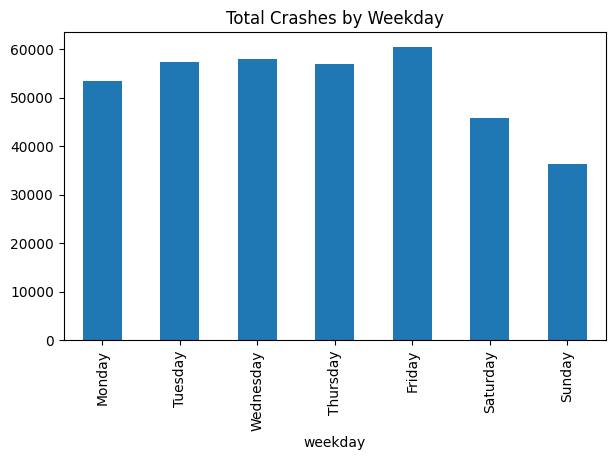

In [16]:
cell_day_df['weekday'] = cell_day_df['date'].dt.day_name()

weekly = cell_day_df.groupby('weekday')['num_crashes'].sum().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
])

weekly.plot(kind='bar', figsize=(7,4), title='Total Crashes by Weekday')

<Axes: title={'center': 'Monthly Crash Totals'}, xlabel='month'>

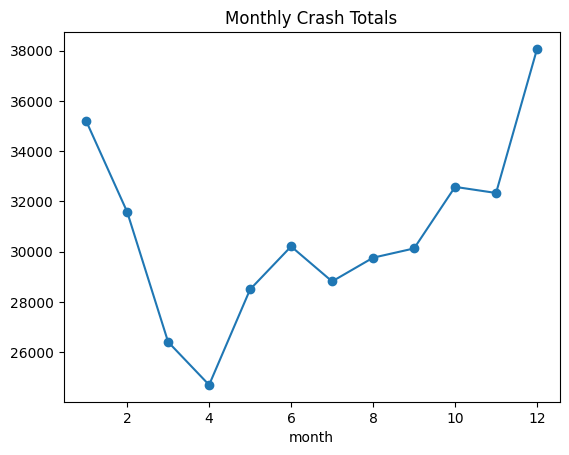

In [17]:
cell_day_df['month'] = cell_day_df['date'].dt.month
monthly = cell_day_df.groupby('month')['num_crashes'].sum()

monthly.plot(kind='line', marker='o', title='Monthly Crash Totals')

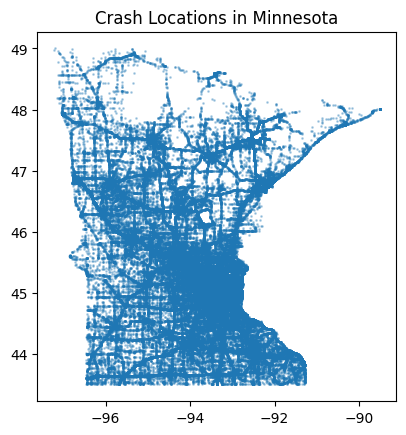

In [18]:
import matplotlib.pyplot as plt

gdf = gpd.GeoDataFrame(df, geometry=df['geometry'], crs='EPSG:4326')

gdf.plot(markersize=1, alpha=0.3)
plt.title("Crash Locations in Minnesota")
plt.show()

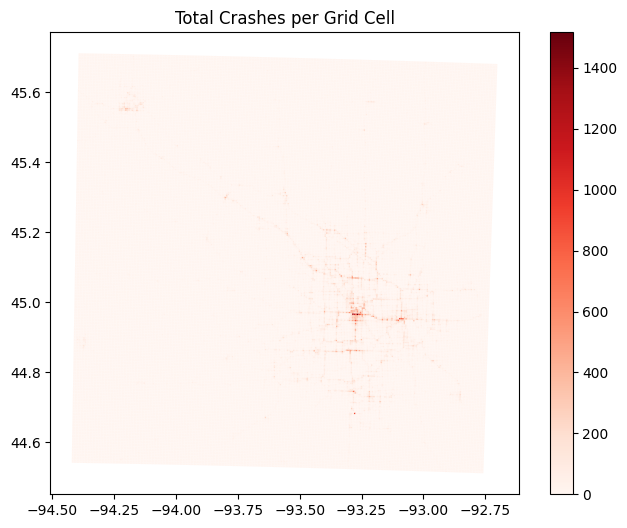

In [19]:
cell_crashes = cell_day_df.groupby('cell_id')['num_crashes'].sum().reset_index()

grid = grid.merge(cell_crashes, on='cell_id', how='left').fillna(0)

grid.plot(column='num_crashes', cmap='Reds', legend=True, figsize=(8,6))
plt.title("Total Crashes per Grid Cell")
plt.show()

# Exploration for Raw Weather Data

In [85]:
# load raw weather data
weather_df = pd.read_csv('../data/raw/weather_data.csv', parse_dates=['DATE'])
weather_df.head(3)

,STATION,NAME,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
0,USW00014918,"INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US",2016-01-01,0.0,0.0,5.9,18.0,24.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014918,"INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US",2016-01-02,0.0,0.0,5.9,18.0,26.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USW00014918,"INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US",2016-01-03,0.0,0.0,5.9,23.0,27.0,21.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
weather_df.info() 
weather_df["NAME"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   STATION  10683 non-null  object        
 1   NAME     10683 non-null  object        
 2   DATE     10683 non-null  datetime64[ns]
 3   PRCP     10678 non-null  float64       
 4   SNOW     10674 non-null  float64       
 5   SNWD     10672 non-null  float64       
 6   TAVG     10549 non-null  float64       
 7   TMAX     10645 non-null  float64       
 8   TMIN     10647 non-null  float64       
 9   TOBS     1383 non-null   float64       
 10  WT01     3496 non-null   float64       
 11  WT02     1020 non-null   float64       
 12  WT03     756 non-null    float64       
 13  WT04     23 non-null     float64       
 14  WT05     75 non-null     float64       
 15  WT06     937 non-null    float64       
 16  WT08     1355 non-null   float64       
 17  WT09     92 non-null     float6

NAME
INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US     3561
ROCHESTER INTERNATIONAL AIRPORT, MN US               3561
MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US    3561
Name: count, dtype: int64

In [98]:
# check percentage of missing values per column
weather_df.groupby("NAME").apply(lambda g: g.isna().mean()*100, include_groups=False).round(2)

,STATION,DATE,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,TOBS,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,precip_day,snow_day,freezing_day
NAME,,,,,,,,,,,,,,,,,,,,
"INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US",0.0,0.0,0.14,0.25,0.31,1.80,1.07,1.01,100.00,50.35,91.24,91.43,99.94,99.83,98.90,72.62,99.10,0.0,0.0,0.0
"MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US",0.0,0.0,0.00,0.00,0.00,1.01,0.00,0.00,61.16,97.25,88.46,99.02,99.58,98.06,77.65,98.99,100.00,0.0,0.0,0.0
"ROCHESTER INTERNATIONAL AIRPORT, MN US",0.0,0.0,0.00,0.00,0.00,0.95,0.00,0.00,100.00,54.23,91.66,88.32,99.83,100.00,97.14,90.34,98.32,0.0,0.0,0.0


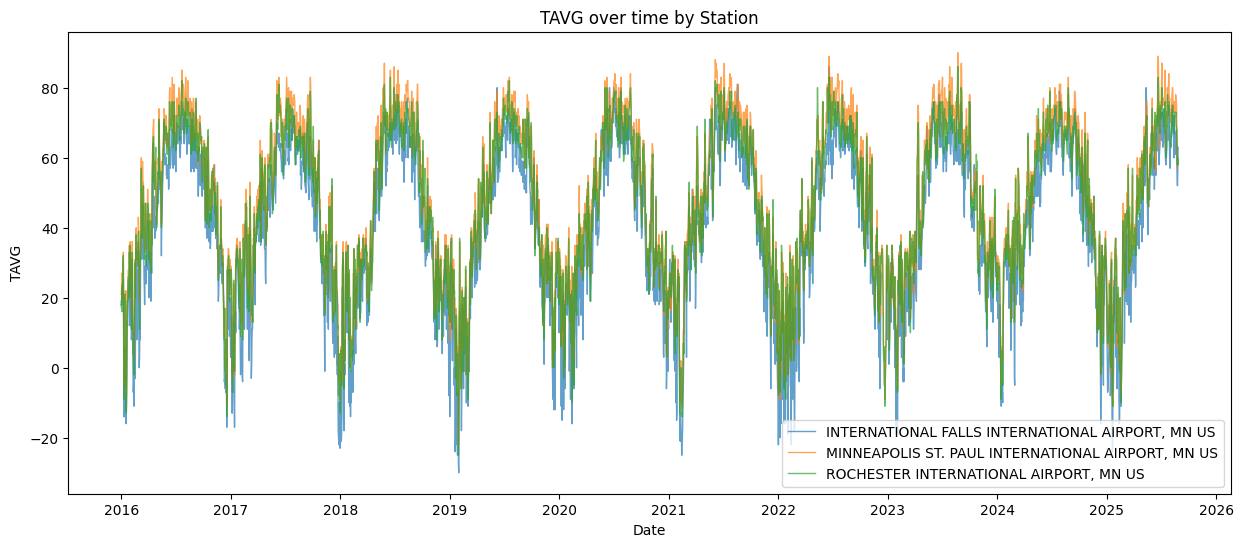

In [ ]:
weather_df["year"] = weather_df["DATE"].dt.year
weather_df["month"] = weather_df["DATE"].dt.month
weather_df["dayofyear"] = weather_df["DATE"].dt.dayofyear

# visualize Average Temparture over time for each station
plt.figure(figsize=(15, 6))
for station, g in weather_df.groupby("NAME"):
    g_sorted = g.sort_values("DATE")
    plt.plot(g_sorted["DATE"], g_sorted["TAVG"], label=station, linewidth=1, alpha=0.7)
plt.title("TAVG over time by Station")
plt.xlabel("Date")
plt.ylabel("TAVG")
plt.legend()
plt.show()

<Axes: xlabel='month'>

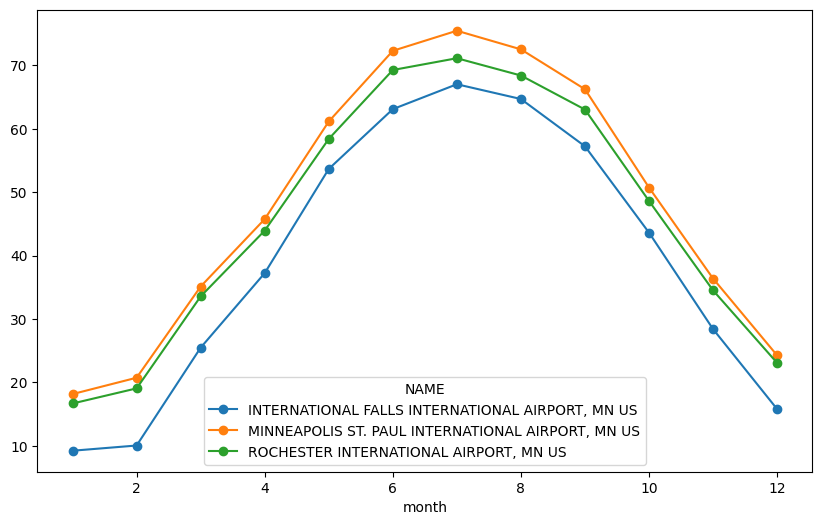

In [51]:
# visualize average monthly temperature trends for each station - seasonal patterns
weather_df.groupby(["NAME", "month"])["TAVG"].mean().unstack("NAME").plot(kind='line', marker='o', figsize=(10,6))

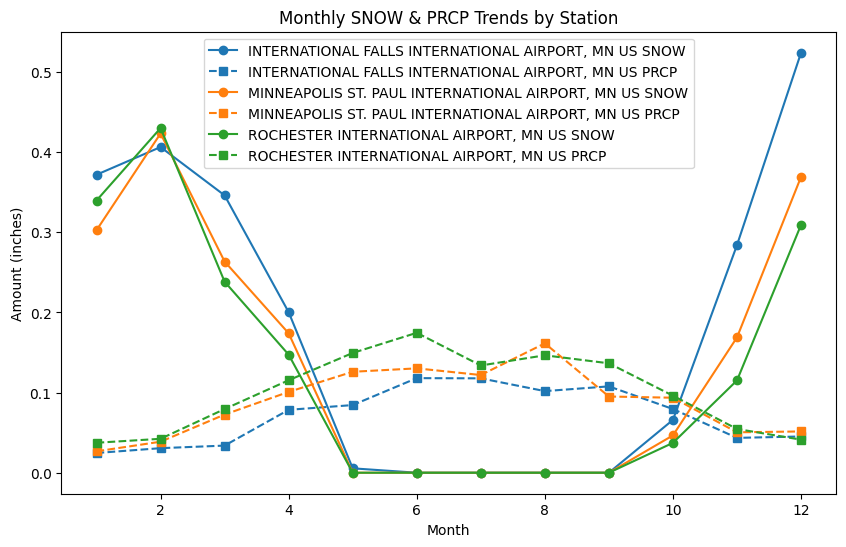

In [71]:
fig, ax = plt.subplots(figsize=(10,6))
monthly = weather_df.groupby(["NAME", "month"])[["SNOW", "PRCP"]].mean().reset_index()

# visualize SNOW and PRCP trends for each station by month
name = monthly["NAME"].unique()
for i, name in enumerate(name):
    snow_data = monthly[monthly["NAME"] == name]
    prcp_data = monthly[monthly["NAME"] == name]
    color = colors[i % len(colors)]
    ax.plot(snow_data["month"], snow_data["SNOW"], marker='o', label=f'{name} SNOW', color=color)
    ax.plot(prcp_data["month"], prcp_data["PRCP"], marker='s', label=f'{name} PRCP', color=color, linestyle='--')
ax.set_title("Monthly SNOW & PRCP Trends by Station")
ax.set_xlabel("Month")
ax.set_ylabel("Amount (inches)")
ax.legend()
plt.show()

- WT01	Fog, ice fog, or freezing fog (or haze)
- WT02	Heavy fog or thick fog
- WT03	Thunder
- WT04	Ice pellets, sleet, snow pellets, or small hail
- WT05	Hail (larger)
- WT06	Glaze or rime (freezing rain)
- WT08	Smoke or ash
- WT09	Blowing or drifting snow

In [77]:
# analyze weather condition indicators (WT01 to WT09)
wt_cols = [c for c in weather_df.columns if c.startswith("WT")]
weather_df[wt_cols].sum()
weather_df.groupby("NAME")[wt_cols].sum()


,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
NAME,,,,,,,,
"INTERNATIONAL FALLS INTERNATIONAL AIRPORT, MN US",1768.0,312.0,305.0,2.0,6.0,39.0,975.0,32.0
"MINNEAPOLIS ST. PAUL INTERNATIONAL AIRPORT, MN US",98.0,411.0,35.0,15.0,69.0,796.0,36.0,0.0
"ROCHESTER INTERNATIONAL AIRPORT, MN US",1630.0,297.0,416.0,6.0,0.0,102.0,344.0,60.0


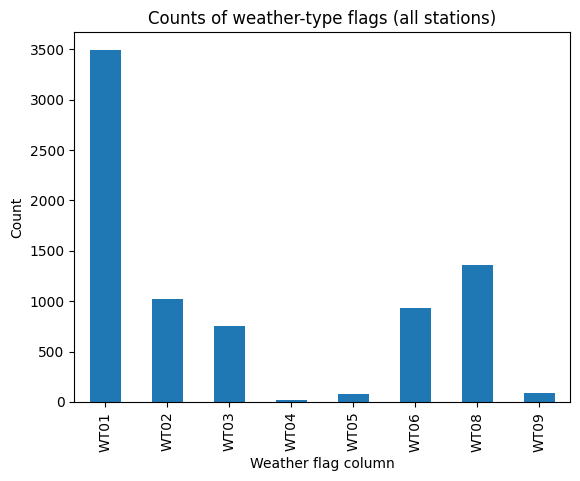

In [79]:
event_counts = weather_df[wt_cols].fillna(0).sum()
plt.figure()
event_counts.plot(kind="bar")
plt.title("Counts of weather-type flags (all stations)")
plt.xlabel("Weather flag column")
plt.ylabel("Count")
plt.show()


In [94]:
# check for any outliers
weather_df[["TMAX", "TMIN", "PRCP", "SNOW", "SNWD"]].describe() 

,TMAX,TMIN,PRCP,SNOW,SNWD
count,10645.000000,10647.000000,10678.000000,10674.000000,10672.000000
mean,54.386754,35.087349,0.088172,0.151780,2.121121
std,24.052911,22.724131,0.262424,0.740358,4.573275
min,-19.000000,-46.000000,0.000000,0.000000,0.000000
25%,35.000000,21.000000,0.000000,0.000000,0.000000
50%,57.000000,36.000000,0.000000,0.000000,0.000000
75%,76.000000,54.000000,0.030000,0.000000,1.200000
max,101.000000,82.000000,4.900000,12.800000,28.000000
